In [12]:
import numpy as np
import matplotlib.pyplot as plt
from qreservoirpy import QReservoir, Layers, utilities

from qiskit.extensions import HamiltonianGate


## Initialization

In [13]:
n_qubits = 4
SHOTS = 10000
timeseries = [0, 1, 2, 3, 0, 1, 2, 2, 3] * 10
encoder = {
    0: '00',
    1: '01',
    2: '10',
    3: '11'
} 

T = 10#s
H = utilities.random_ising_H(num_qubits=n_qubits, num_terms=80)
UT = HamiltonianGate(H, T, label="UT")


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
models = np.array([
    SVC(kernel=ker) for ker in ['linear', 'poly', 'rbf', 'sigmoid']
] + [
    RidgeClassifier(alpha=alph) for alph in np.linspace(0, 1e-3, 9)
] + [
    KNeighborsClassifier(n_neighbors=n) for n in range(1, 10)
], dtype=object)



In [15]:

def build_method(circuit, timestep, encoding, reservoir):
    circuit.measure(range(2))
    circuit.initialize(encoding[timestep], range(2))
    circuit.unitary(reservoir, circuit.qubits)

qres = QReservoir(qubits=n_qubits, layers=[
    Layers.Reset(),
    Layers.Timeseries(build_method=build_method, 
                      encoding = encoder,
                      reservoir = UT)
])
qres.circuit.draw('mpl')


## Running

In [16]:
states = qres.run(
    timeseries=timeseries, 
    shots=SHOTS
)


Simulating:   0%|          | 0/1 [00:00<?, ?it/s]

Simulating: 100%|██████████| 1/1 [00:11<00:00, 11.70s/it]


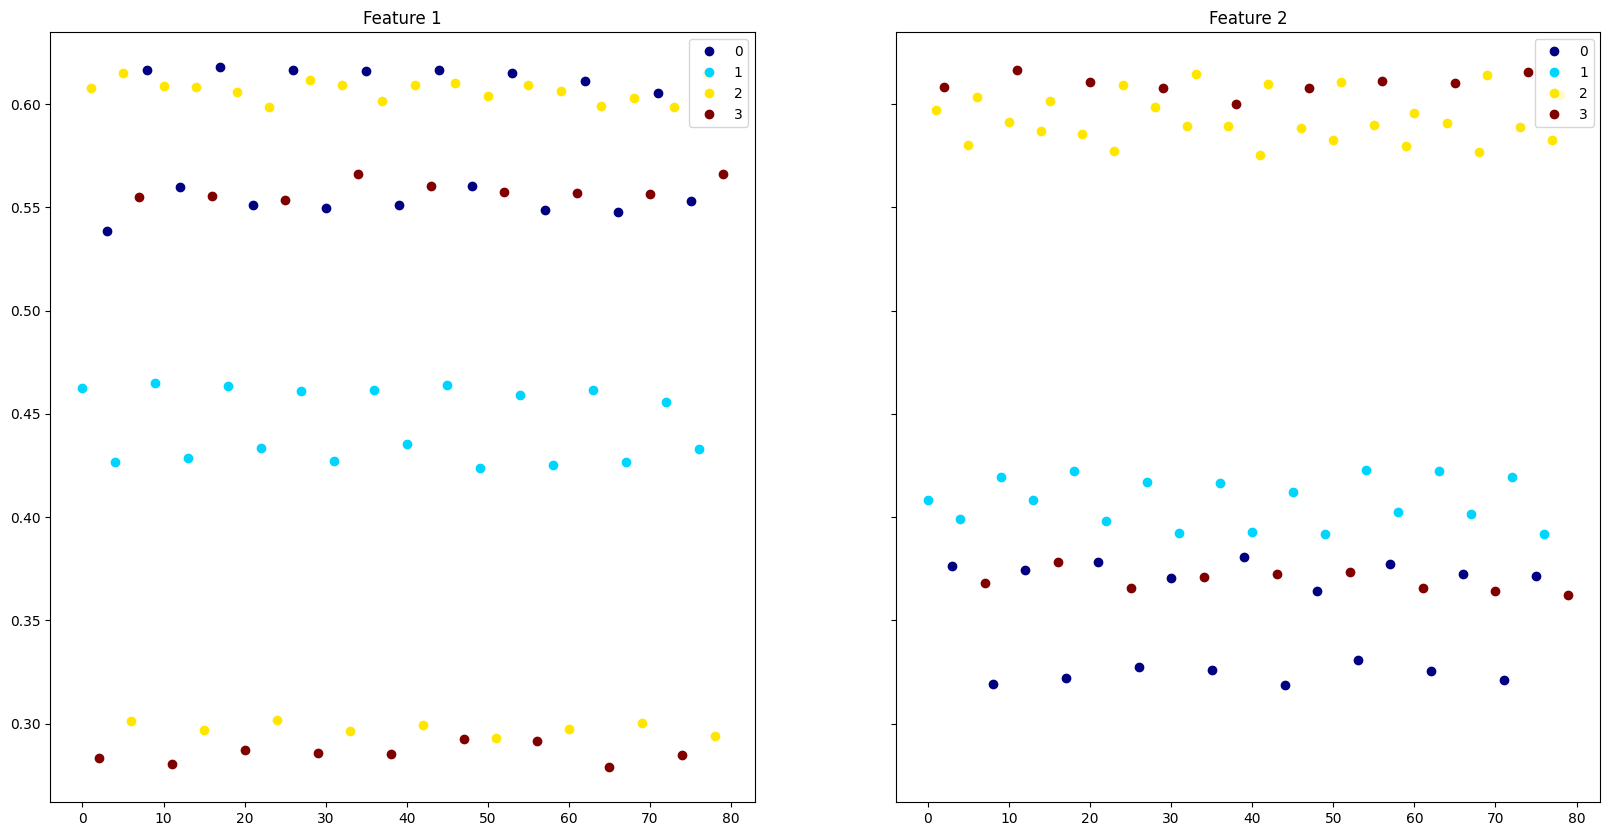

In [17]:
WARMUP = 0.1 # 10%
warmup_idx = int(len(states) * WARMUP)

xstates = states[:-1][warmup_idx:]
target = timeseries[1:][warmup_idx:]
fig, ax = utilities.result_plotter(xstates, target)

Text(0, 0.5, 'state 2')

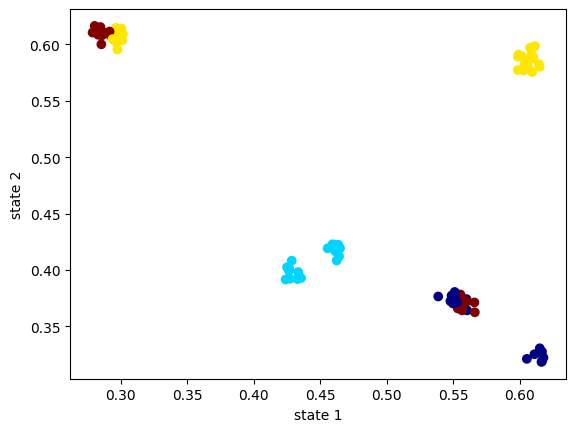

In [18]:



cmap = plt.get_cmap('jet', len(np.unique(timeseries)))

plt.scatter(xstates[:, 0], xstates[:, 1], cmap=cmap, c=target)

plt.xlabel("state 1")
plt.ylabel("state 2")


## Training

In [19]:


results = utilities.stress_test_models(xstates, target, models, test_to_train_ratio=1/3)
sorting = np.flip(np.argsort(results))
for model, res in zip(models[sorting], results[sorting]):
    print(f'Score of {model}: {res}')
    

model = models[sorting][0]


Score of KNeighborsClassifier(n_neighbors=3): 0.9037037037037028
Score of KNeighborsClassifier(): 0.9007407407407395
Score of KNeighborsClassifier(n_neighbors=4): 0.8885185185185178
Score of KNeighborsClassifier(n_neighbors=6): 0.8848148148148138
Score of KNeighborsClassifier(n_neighbors=1): 0.8762962962962954
Score of KNeighborsClassifier(n_neighbors=2): 0.8748148148148138
Score of KNeighborsClassifier(n_neighbors=7): 0.8651851851851842
Score of KNeighborsClassifier(n_neighbors=8): 0.8451851851851845
Score of SVC(kernel='poly'): 0.8188888888888883
Score of KNeighborsClassifier(n_neighbors=9): 0.8062962962962956
Score of SVC(): 0.7403703703703703
Score of RidgeClassifier(alpha=0.0): 0.668148148148148
Score of RidgeClassifier(alpha=0.001): 0.668148148148148
Score of RidgeClassifier(alpha=0.000875): 0.668148148148148
Score of RidgeClassifier(alpha=0.00075): 0.6677777777777777
Score of RidgeClassifier(alpha=0.000375): 0.6677777777777777
Score of RidgeClassifier(alpha=0.0005): 0.6677777777

## Predicting

In [20]:
predict_from = timeseries[-20:]
num_preds = 40


pred_states, preds = qres.predict(
    num_pred=num_preds,
    model=model,
    shots=SHOTS,
    from_series=predict_from
)


Predicting: 100%|██████████| 1620/1620 [03:06<00:00,  8.69it/s]


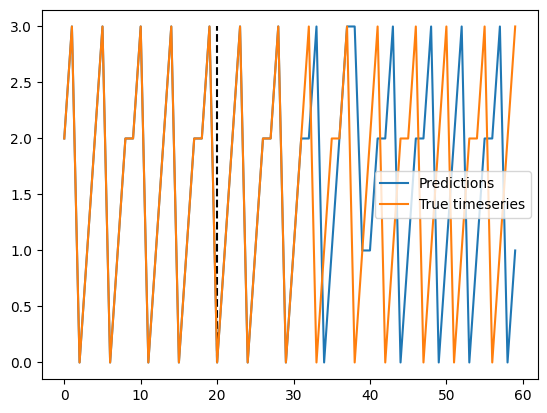

In [21]:
true_values = timeseries

pred_plot = np.append(predict_from[-num_preds:], preds)
true_plot = np.append(predict_from[-num_preds:], true_values)

minlen = min(len(pred_plot), len(true_plot))

plt.plot(pred_plot[:minlen], label="Predictions")
plt.vlines(len(predict_from[-num_preds:]), ymin=np.min(target), ymax=np.max(target), colors='k', linestyles='dashed')
plt.plot(true_plot[:minlen], label="True timeseries")
plt.legend()

In [22]:
from qreservoirpy import music

music_encoding = {
    0: ('P', 1/4),
    1: (60, 1/4),
    2: (64, 1/4),
    3: (67, 1/4),
}


notes = [music_encoding[elem] for elem in pred_plot]
music.gen_audio(notes, filename="music/discrete7.wav", BPM=160)